In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir data

In [3]:
!unzip -qq "/content/drive/MyDrive/panda.zip" -d "/content/data"

In [4]:
import torch
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import imageio
import pandas as pd

In [5]:
def create_class_mapping(data_dir):
    filenames = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
    class_names = set(os.path.splitext(f)[0] for f in filenames)

    class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(class_names))}
    print(class_mapping)
    return class_mapping

data_dir = '/content/data'
class_mapping = create_class_mapping(data_dir)

{'apple': 0, 'basketball': 1, 'bed': 2, 'cat': 3, 'helicopter': 4, 'leg': 5, 'panda': 6, 'piano': 7, 'umbrella': 8, 'washingmachine': 9, 'windmill': 10}


In [6]:
class QuickDrawDataset(Dataset):
    def __init__(self, data_dir, class_mapping, transform=None, max_images_per_class=10000):
        self.data_dir = data_dir
        self.transform = transform
        self.class_mapping = class_mapping
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]

        # Calculate the total number of images, capping at max_images_per_class
        self.total_images = sum(min(np.load(os.path.join(data_dir, f)).shape[0], max_images_per_class) for f in self.data_files)

        self.data_info = []
        for file_path in self.data_files:
            data = np.load(file_path)
            num_images = min(data.shape[0], max_images_per_class)
            self.data_info.append((file_path, num_images))

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        cumulative_count = 0
        for file_path, num_images in self.data_info:
            if idx < cumulative_count + num_images:
                break
            cumulative_count += num_images

        data = np.load(file_path)
        image_idx = idx - cumulative_count
        image = data[image_idx].reshape(28, 28) / 255
        image = image[np.newaxis, ...]  # Add channels dimension

        label_name = os.path.splitext(os.path.basename(file_path))[0]
        label = self.class_mapping[label_name]
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label


Số lượng phần tử của tập Train: 11000
Shape của image: (1, 28, 28)
Nhãn: 0


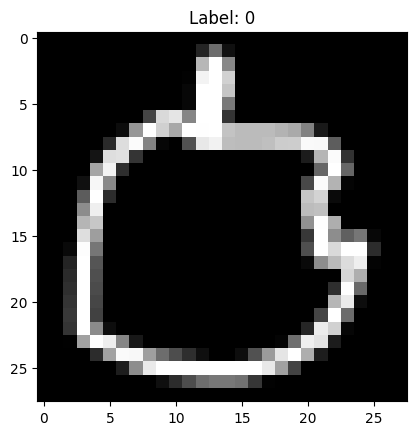

In [23]:
import matplotlib.pyplot as plt

train_dataset = QuickDrawDataset(
    data_dir="/content/data",
    class_mapping=class_mapping,
    transform=None,
    max_images_per_class=1000
)

# gọi hàm __len__ bằng lệnh len(train_dataset)
print(f"Số lượng phần tử của tập Train: {len(train_dataset)}")

# gọi hàm __getitem__ bằng lệnh train_dataset[index]
index = 1
image, label = train_dataset[index]

print(f"Shape của image: {image.shape}")
print(f"Nhãn: {label}")
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [24]:
train_indices, remaining_indices = train_test_split(
    range(len(train_dataset)),
    test_size=0.2,
)

test_indices, val_indices = train_test_split(
    remaining_indices,
    test_size=0.5,
)

train_dataset_subset = Subset(train_dataset, train_indices)
test_dataset_subset = Subset(train_dataset, test_indices)
val_dataset_subset = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_dataset_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_subset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset_subset, batch_size=128, shuffle=False)



In [25]:
for batch in train_loader:
    batch_image, batch_label = batch
    print(batch_image.shape)
    print(batch_label)

    break

torch.Size([128, 1, 28, 28])
tensor([ 1,  1,  7, 10,  0,  9,  4,  2,  6,  7,  5,  3,  5,  1,  0, 10, 10,  1,
         0,  0,  2,  5,  3, 10,  4,  1,  4,  3,  7,  7,  4,  7,  3,  6,  3,  2,
         1,  3,  6,  2, 10,  4,  9,  5, 10,  0,  1,  8,  5,  8,  4,  7,  4, 10,
         9,  0,  3,  2,  8,  6,  7,  4, 10,  7,  7,  8,  7,  7,  4,  2,  7,  2,
         3,  9,  1,  1,  8,  9,  1, 10,  8,  8,  7,  1,  9,  5,  4,  8,  4,  7,
         1,  1,  3,  2,  3,  3,  4,  7,  5,  4,  7,  1,  3,  5,  6,  1,  3,  2,
         2,  1,  3,  2,  2,  5,  9,  4,  1, 10,  5,  1,  8,  1,  6,  4,  6,  3,
         2,  9])


In [26]:
import numpy as np
import pickle
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.utils.data import DataLoader
import torch.optim as optim


In [27]:
class CNNModel(nn.Module):
  def __init__(self, numChannels, classes):
    super(CNNModel, self).__init__()
    self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    self.fc1 = Linear(in_features=800, out_features=500)
    self.relu3 = ReLU()
    self.fc2 = Linear(in_features=500, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.maxpool2(x)
      x = flatten(x, 1)
      x = self.fc1(x)
      x = self.relu3(x)
      x = self.fc2(x)
      output = self.logSoftmax(x)
      return output


In [28]:
model = CNNModel(1,11)
rand = torch.rand(1,1,28,28)
model(rand).shape

torch.Size([1, 11])

In [45]:
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [46]:
from google.colab import files

train_loss_plot = []
val_loss_plot = []
val_acc_plot = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_plot.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.float().to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total
    val_loss_plot.append(avg_val_loss)
    val_acc_plot.append(accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    model_path = '/content/model' + str(epoch) + '.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'accuracy': accuracy,
        'val_loss': avg_val_loss,

    }, model_path)
    print(f'Model saved at {model_path}')


Epoch [1/10], Loss: 0.3485
Validation Loss: 0.4258, Accuracy: 87.27%
Model saved at /content/model0.pth
Epoch [2/10], Loss: 0.2976
Validation Loss: 0.4204, Accuracy: 88.09%
Model saved at /content/model1.pth
Epoch [3/10], Loss: 0.2595
Validation Loss: 0.3888, Accuracy: 88.00%
Model saved at /content/model2.pth
Epoch [4/10], Loss: 0.2144
Validation Loss: 0.3719, Accuracy: 89.18%
Model saved at /content/model3.pth
Epoch [5/10], Loss: 0.1873
Validation Loss: 0.3845, Accuracy: 88.55%
Model saved at /content/model4.pth
Epoch [6/10], Loss: 0.1568
Validation Loss: 0.3968, Accuracy: 88.00%
Model saved at /content/model5.pth
Epoch [7/10], Loss: 0.1197
Validation Loss: 0.4041, Accuracy: 88.36%
Model saved at /content/model6.pth
Epoch [8/10], Loss: 0.0968
Validation Loss: 0.4354, Accuracy: 89.27%
Model saved at /content/model7.pth
Epoch [9/10], Loss: 0.0879
Validation Loss: 0.4166, Accuracy: 89.18%
Model saved at /content/model8.pth
Epoch [10/10], Loss: 0.0628
Validation Loss: 0.4551, Accuracy: 8

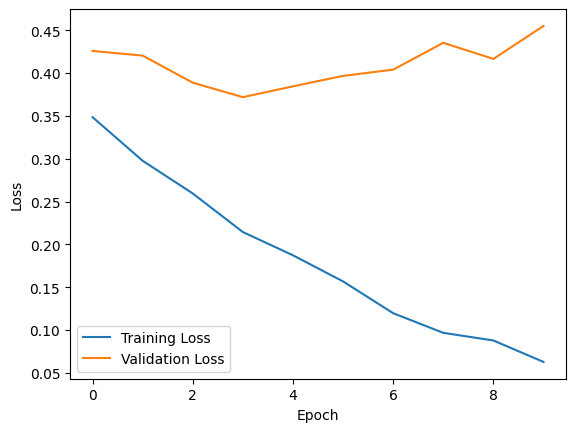

In [47]:
import matplotlib.pyplot as plt

plt.plot(train_loss_plot, label='Training Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

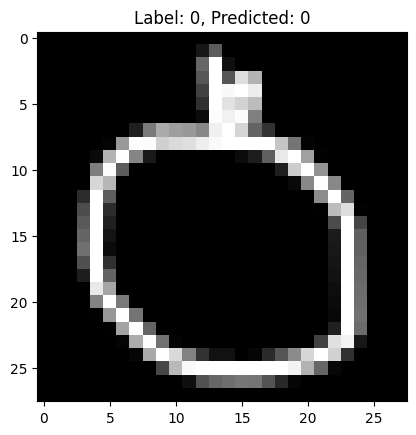

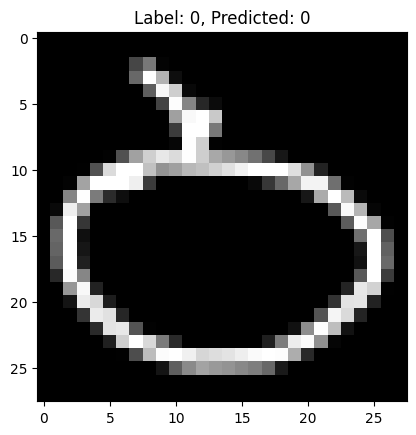

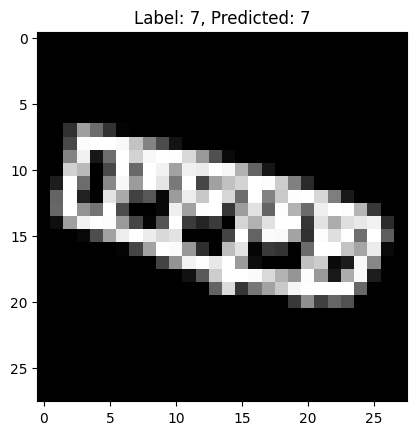

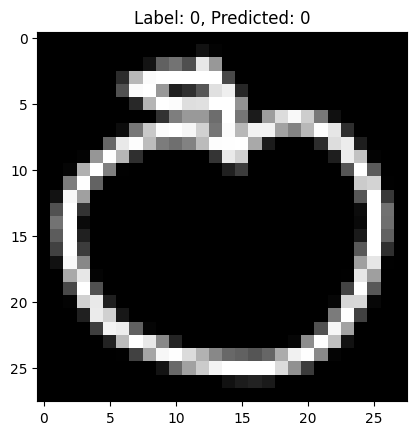

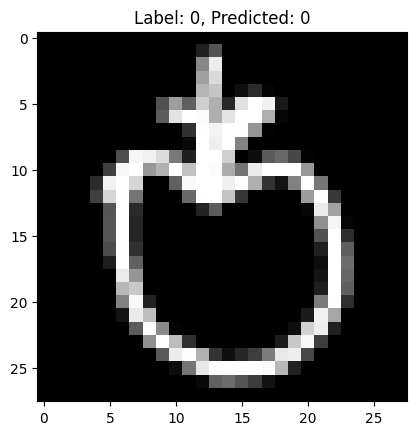

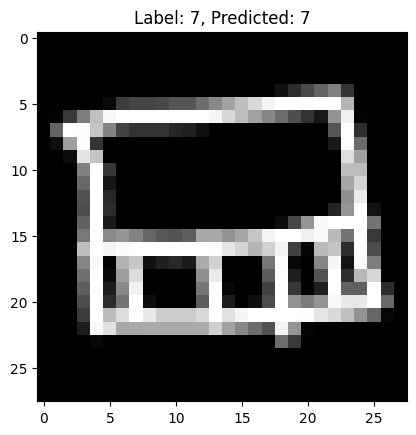

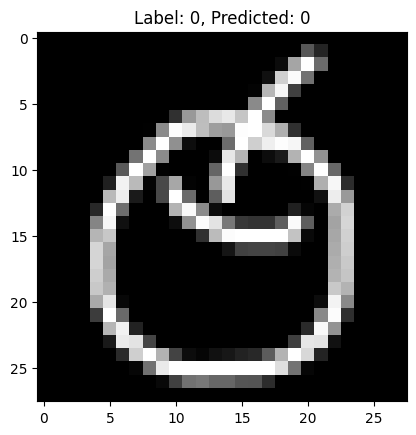

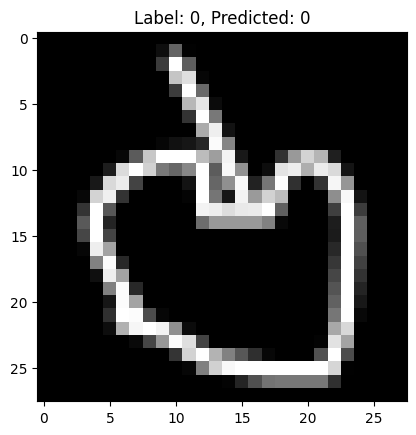

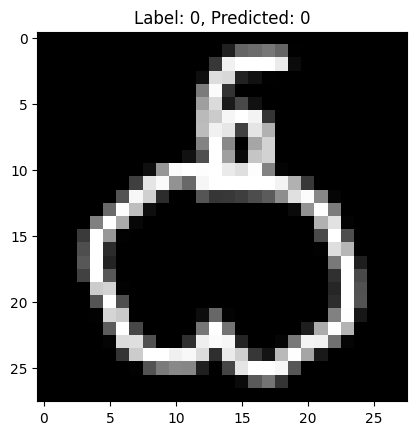

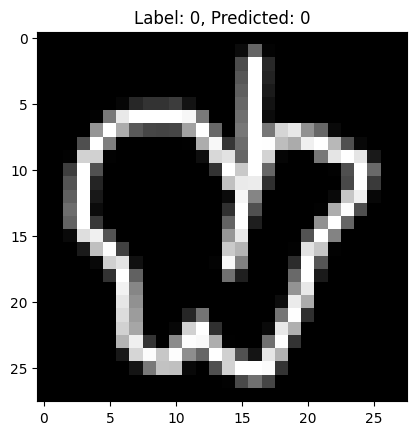

In [48]:
indexes = np.random.randint(0, 2000, 10)
for index in indexes:
    image, label = train_dataset[index]
    model.eval()
    with torch.no_grad():
        image = torch.tensor(image).float()
        img = image[np.newaxis, ...]
        img = img.to(device)
        output = model(img)
        _, predicted = torch.max(output, 1)

    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.title(f"Label: {label}, Predicted: {predicted.item()}")
    plt.show()


In [32]:
while True:
    pass

KeyboardInterrupt: 